In [2]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [4]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [5]:
models = {
    "alibaba/qwen2.5-14b-instruct": {
        "label": "Qwen2.5-14B", 
        "color": "#FCEDCB",
    },
    "openrouter-deepseek/deepseek-r1-distill-qwen-14b": {
        "label": "Deepseek-Distill-Qwen-14B", 
        "color": "#FADFA1",
    },   
    "deepseek-ai/deepseek-reasoner": {
        "label": "DeepsSeek-R1", 
        "color": colors[4],
    }, 
}


metrics = {
    "average_forgetting_rate": {
        "label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": "Average Solution Count",
    },
    "overall_average_verification_rate": {
        "label": "Average Verification Rate",
    },
    "filtered_ajd": {
        "label": "Average Jump Distance",
    },
    "average_success_rate": {
        "label": "Average Success Rate",
    },
    "average_overthinking_rate": {
        "label": "Average Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [6]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [7]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        
        row = get_row(
            task_vis_results, 
            model_name=model, 
            dataset_name=dataset, 
        )
        for metric in final_metrics:
            if metric not in reasoning_metrics[dataset]:
                reasoning_metrics[dataset][metric] = {}
            

            reasoning_metrics[dataset][metric][model] = row.iloc[0][metric]


In [8]:
model_pairs = list(itertools.combinations(models, 2))
similarities = {"tree": {}, "walk": {}}

for model_pair in model_pairs:
    for dataset in final_datasets:
        model1, model2 = sorted(model_pair)
        row = get_row(
            compare_results,
            model1=model1,
            model2=model2,
            dataset=dataset,
        )
        similarities["tree"][(model1, model2, dataset)] = row.iloc[0]["tree_similarity"]
        similarities["walk"][(model1, model2, dataset)] = row.iloc[0]["walk_similarity"]
    
    

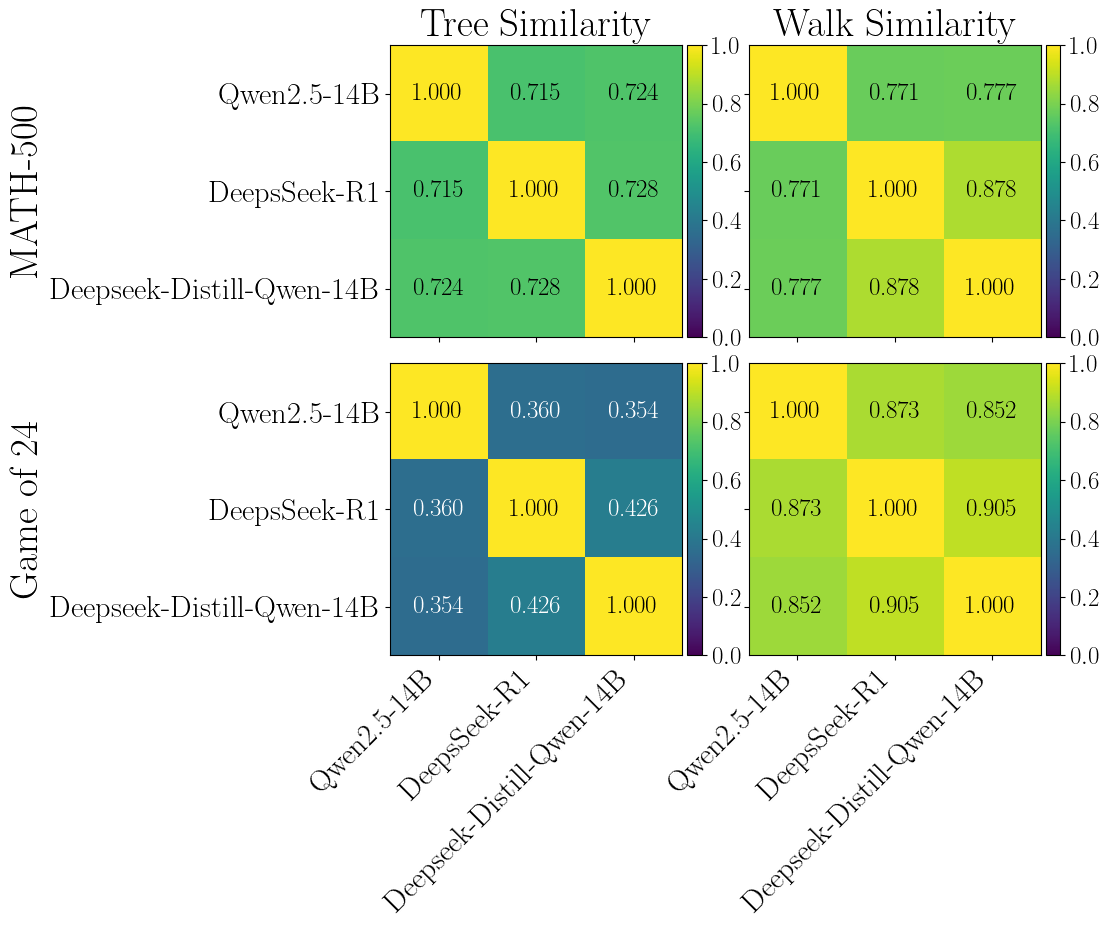

In [9]:
# Create a figure with 4 subplots (2x2 grid) for the heatmaps
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(left=0.28, bottom=.1, right=0.95, top=1.05, wspace=0.15, hspace=-0.35)
fig.set_size_inches(10, 8.5)

# Define the metrics and datasets for the subplots
similarity_metrics = ["tree", "walk"]
datasets_list = list(final_datasets.keys())

# Create a mapping for model names to indices for the heatmap
model_names = sorted(list(set([m for pair in model_pairs for m in pair])))
model_indices = {model: i for i, model in enumerate(model_names)}
model_labels = [models[model]["label"] for model in model_names]

# Create the heatmaps
for dataset_idx, dataset in enumerate(datasets_list[:2]):  # Using first two datasets
    for metric_idx, metric in enumerate(similarity_metrics):
        # Calculate subplot index
        subplot_idx = dataset_idx * 2 + metric_idx
        current_ax = axs[dataset_idx, metric_idx]
        
        # Create empty similarity matrix
        sim_matrix = np.zeros((len(model_names), len(model_names)))
        
        # Fill diagonal with 1.0 (self-similarity)
        np.fill_diagonal(sim_matrix, 1.0)
        
        # Fill the matrix with similarity values
        for model1, model2 in model_pairs:
            i, j = model_indices[model1], model_indices[model2]
            # Get similarity value, defaulting to NaN if not found
            sim_value = similarities[metric].get((model1, model2, dataset), 
                                               similarities[metric].get((model2, model1, dataset), np.nan))
            sim_matrix[i, j] = sim_value
            sim_matrix[j, i] = sim_value  # Symmetrical matrix
        
        # Create heatmap
        im = current_ax.imshow(sim_matrix, cmap='viridis', vmin=0, vmax=1)
        
        # Add colorbar with the same height as the heatmap

        divider = make_axes_locatable(current_ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        # cbar.set_label(f'{metric.capitalize()} Similarity')
        
        # Make the colorbar tick labels smaller
        cbar.ax.tick_params(labelsize=18)
        
        # Set title and labels
        # current_ax.set_title(f"{final_datasets[dataset]} - {metric.capitalize()} Similarity")
        current_ax.set_xticks(np.arange(len(model_names)))
        current_ax.set_yticks(np.arange(len(model_names)))
        current_ax.set_xticklabels(model_labels, rotation=45, ha="right",fontsize=22)
        current_ax.set_yticklabels(model_labels,fontsize=22)
        
        # Add text annotations in the heatmap cells
        for i in range(len(model_names)):
            for j in range(len(model_names)):
                text_color = "white" if sim_matrix[i, j] < 0.5 else "black"
                current_ax.text(j, i, f"{sim_matrix[i, j]:.3f}", 
                                     ha="center", va="center", color=text_color, fontsize=18)

# Add y-axis labels for each row (dataset name)
for dataset_idx, dataset in enumerate(datasets_list[:2]):
    # Add label to the first subplot of each row
    axs[dataset_idx, 0].set_ylabel(final_datasets[dataset], fontsize=28, fontweight='bold')

# Add x-axis labels at the top for each column (metric name)
for metric_idx, metric in enumerate(similarity_metrics):
    # Add label to the top subplot of each column
    axs[0, metric_idx].set_title(f"{metric.capitalize()} Similarity", fontsize=28, fontweight='bold')

plt.savefig(f"{root_dir}/figures/distill_14b_similarities.pdf")
plt.show()
